# Face Recognition against My Photo Library
The iCloud photos from iOS or Mac OS provided a comprenesive way to tag faces and then all the photos in the library will be scanned, faces will be identified and tagged accordingly based on the earlier user defined tags.

I am a photography enthusiast and I have started to taking photos from year 2004. As of today, it's over 200k shots and I've kept 40k of them. There are many desktop applications can do the job of face recognition, but it's going to be super fun if I can build the solution end to end.

This report will have following parts.
1. Get photos and preprocess.
2. Get the features of the baseine photos.
3. Train the model to perform the classification.
4. Evaluate the model.

## Part 1 - Get photos and preprocessing
### A glance at the folder structure
All my photos are in `D:\Pictures`, majority of them are in both `.jpg` and `.nef` format. The `.nef` is a raw image format for Nikon cameras and `.jpg` is the copy after image post-processing of raw file.

In [1]:
import os
import time
cur_dir = os.getcwd()
print(cur_dir)
target_image_dir = os.path.join(cur_dir, 'images')
photo_dir = 'D:\Pictures'
os.listdir(photo_dir)

D:\Google Drive\Study\Deep Learning Developer\Projects\Project 4 - Face Recognition Against My Photo Library


['.SynologyWorkingDirectory',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 'Adobe Lightroom',
 'Camera Roll',
 'desktop.ini',
 'iCloud Photos',
 'naming instruction.txt',
 'Phone Photos',
 'Photography Works',
 'Saved Pictures',
 'zbingjie',
 'zothers',
 '法蝶',
 '熊思宇和黄乐论辩论']

One sample of a recent photo directory. Each and every file use the time stamp as its file name. `.nef` is the raw image file, `.xmp` is generated by Adobe Lightroom, both are not applicable to this project.

In [2]:
os.listdir(photo_dir + '/2017/2017.11.16 - Singapore Fintech Festival')

['20171112-2038.jpg',
 '20171112-2038.NEF',
 '20171112-2038.xmp',
 '20171112-2039.jpg',
 '20171112-2039.NEF',
 '20171112-2039.xmp',
 '20171116-1705.jpg',
 '20171116-1705.NEF',
 '20171116-1705.xmp',
 '20171116-1707.jpg',
 '20171116-1707.NEF',
 '20171116-1707.xmp',
 '20171116-1708.jpg',
 '20171116-1708.NEF',
 '20171116-1708.xmp',
 '20171116-1709.jpg',
 '20171116-1709.NEF',
 '20171116-1709.xmp',
 '20171116-1710.jpg',
 '20171116-1710.NEF',
 '20171116-1710.xmp',
 '20171116-1713.jpg',
 '20171116-1713.NEF',
 '20171116-1713.xmp',
 '20171116-1715.jpg',
 '20171116-1715.NEF',
 '20171116-1715.xmp',
 '20171116-1716.jpg',
 '20171116-1716.NEF',
 '20171116-1716.xmp',
 '20171116-1717.jpg',
 '20171116-1717.NEF',
 '20171116-1717.xmp',
 '20171116-1718-2.jpg',
 '20171116-1718-2.NEF',
 '20171116-1718-2.xmp',
 '20171116-1718.jpg',
 '20171116-1718.NEF',
 '20171116-1718.xmp',
 '20171116-1720.jpg',
 '20171116-1720.NEF',
 '20171116-1720.xmp',
 '20171116-1721-2.jpg',
 '20171116-1721-2.NEF',
 '20171116-1721-2.xmp'

### Create face images
Iteratively going through all the images and save the face to a jpg file into the working directory. The value of the scaling factor in the cascade classifier affects the number of false positive. Some manual process will be needed.

In [3]:
# Import required libraries for this section
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import time

In [4]:
def show_faces(file_path, display=False, save=False):
    print('Image path', file_path)
    
    # The file path contains unicode characters, cannot use cv2.imread() directly
    file_stream = open(file_path, 'rb')
    bytes_arr = bytearray(file_stream.read())
    numpy_ar = np.asarray(bytes_arr, dtype=np.uint8)
    image = cv2.imdecode(numpy_ar, cv2.IMREAD_UNCHANGED)
    print(image.shape)
    
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the RGB  image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Print the number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # Make a copy of the orginal image to draw face detections on
    image_with_detections = np.copy(image)

    # The list of detected faces
    image_faces = []
    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        # Add a red bounding box to the detections image
        if w > 200:
            line_width = w//20
        else:
            line_width = 3
        image_faces.append(image[y:(y+h), x:(x+w)])
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), line_width)
    
    if save:
        save_faces(file_path, image_faces)

    if display:
        # Display the image with the detections
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
        ax.set_title('Sample Image')
        ax.imshow(image_with_detections)
    os.chdir(cur_dir)

In [5]:
# pathlib available from python 3.5
from pathlib import Path
def save_faces(file_path, image_faces):
    if len(image_faces) == 0:
        return
    # Save the each face into individual files
    target_file = file_path.replace(photo_dir, target_image_dir)
    target_dir = os.path.dirname(target_file)
    target_path = Path(target_dir)
    
    # Create parents of directory, don't raise exception if the directory exists
    target_path.mkdir(parents=True, exist_ok=True)
        
    for i, face in enumerate(image_faces):
        face = cv2.resize(face, (299, 299))
        os.chdir(target_dir)
        file_name = os.path.basename(target_file)
        cv2.imwrite(file_name + '-face-' + str(i) + '.jpg', cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        

Image path D:\Pictures\2017\2017.11.16 - Singapore Fintech Festival\20171116-1923.jpg
(4760, 7132, 3)
Number of faces detected: 5


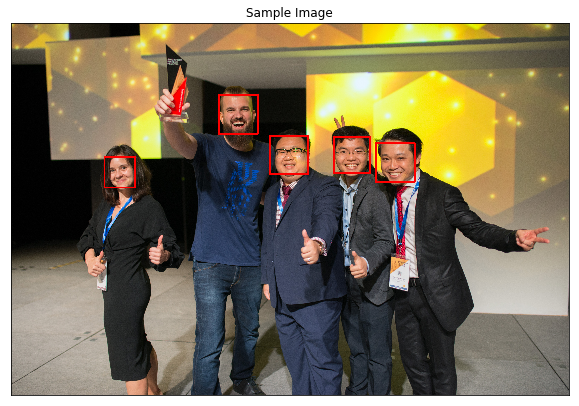

In [6]:
# Load in color image for face detection
file_path = os.path.join(photo_dir, '2017\\2017.11.16 - Singapore Fintech Festival', '20171116-1923.jpg')
show_faces(file_path, True)

In [9]:
all_jpg = []
for root, dirs, files in os.walk(photo_dir):
    # All the target photos are in D:\Pictures\20xx. Get the jpgs from them only.
    path = root.split(os.sep)
    if len(path) < 3:
        continue
    else:
        year = path[2]
        if year[:2] != '20':
            continue
    #print((len(path) - 1) * '---', os.path.basename(root))
    for file in files:
        if file[-3:].lower() == 'jpg':
            #print(len(path) * '---', file)
            all_jpg.append(os.path.join(root, file))

In [10]:
print('Number of jpgs:', len(all_jpg))
all_jpg[:10]

Number of jpgs: 39687


['D:\\Pictures\\2004\\2004.12.16 - 保存的第一张数码照片\\20041216-2037.JPG',
 'D:\\Pictures\\2004\\2004.12.21~24 - 刚到新加坡，bukit timah hill, befriender, 猴子, oldham hall及附近\\20041221-0828.jpg',
 'D:\\Pictures\\2004\\2004.12.21~24 - 刚到新加坡，bukit timah hill, befriender, 猴子, oldham hall及附近\\20041221-0829.jpg',
 'D:\\Pictures\\2004\\2004.12.21~24 - 刚到新加坡，bukit timah hill, befriender, 猴子, oldham hall及附近\\20041221-1004.jpg',
 'D:\\Pictures\\2004\\2004.12.21~24 - 刚到新加坡，bukit timah hill, befriender, 猴子, oldham hall及附近\\20041221-1011-2.jpg',
 'D:\\Pictures\\2004\\2004.12.21~24 - 刚到新加坡，bukit timah hill, befriender, 猴子, oldham hall及附近\\20041221-1011.jpg',
 'D:\\Pictures\\2004\\2004.12.21~24 - 刚到新加坡，bukit timah hill, befriender, 猴子, oldham hall及附近\\20041221-1013.jpg',
 'D:\\Pictures\\2004\\2004.12.21~24 - 刚到新加坡，bukit timah hill, befriender, 猴子, oldham hall及附近\\20041221-1203.jpg',
 'D:\\Pictures\\2004\\2004.12.21~24 - 刚到新加坡，bukit timah hill, befriender, 猴子, oldham hall及附近\\20041221-1219.jpg',
 'D:\\Pictures\\200

In [ ]:
#############################
### RUN WITH CAUSION#########
#############################

# Scan through all 40k photos and extract faces
for i in range(len(all_jpg)):
    show_faces(all_jpg[i], False, True)

### Manully label the face images by putting them into different folders
There are 100k faces identified. Most of them are non-relevant. I hand picked over 200 of them.

In [7]:
os.listdir('./images')

['Test', 'Train', 'Validate']

In [23]:
os.listdir('./images/Test')

['Brother', 'Dad', 'Daughter', 'Me', 'Mum', 'Son', 'Wife']

In [8]:
from sklearn.datasets import load_files
from keras.utils import np_utils
from glob import glob

# Read all the files and return 2 numpy arrays, 1 is the address of the files
# and 1 is the one hot encode of the category.
def load_dataset(path):
    data = load_files(path)
    face_files = np.array(data['filenames'])
    face_targets = np_utils.to_categorical(np.array(data['target']), 7)
    return face_files, face_targets

train_faces, train_targets = load_dataset('./images/Train')
test_faces, test_targets = load_dataset('./images/Test')
validate_faces, validate_targets = load_dataset('./images/Validate')

face_names = [item[15:-1] for item in glob('./images/Train/*/')]

print('There are %d face categories.' % len(face_names))
print(face_names)
print('There are %d total faces.' % len(np.hstack([train_faces, test_faces, validate_faces])))
print('There are %d training faces.' % len(train_faces))
print('There are %d test faces.' % len(test_faces))
print('There are %d validate faces.' % len(validate_faces))

Using TensorFlow backend.


There are 7 face categories.
['Brother', 'Dad', 'Daughter', 'Me', 'Mum', 'Son', 'Wife']
There are 245 total faces.
There are 120 training faces.
There are 58 test faces.
There are 67 validate faces.


In [9]:
# One sample of the returned data structure
print(train_faces[0], train_targets[0])

./images/Train\Daughter\20151101-0848-10.jpg-face-0.jpg [ 0.  0.  1.  0.  0.  0.  0.]


## Part 2 - Transfer learning and train the model

In [10]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback, ReduceLROnPlateau

In [11]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [12]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation = 'relu')(x)
x = Dense(200, activation = 'relu')(x)
x = Dense(50, activation = 'relu')(x)
x = Dense(7, activation = 'softmax')(x)

my_model = Model(inputs = base_model.input, outputs = x)
my_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [14]:
from keras.preprocessing import image

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(299,299))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [15]:
train_tensors = paths_to_tensor(train_faces).astype('float32')/255
test_tensors = paths_to_tensor(test_faces).astype('float32')/255
validate_tensors = paths_to_tensor(validate_faces).astype('float32')/255
print("Train tensor shape.", train_tensors.shape)
print('Test tensor shape.', test_tensors.shape)
print('Validate tensor shape.', validate_tensors.shape)

Train tensor shape. (120, 299, 299, 3)
Test tensor shape. (58, 299, 299, 3)
Validate tensor shape. (67, 299, 299, 3)


In [16]:
my_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='my_model.h5',
                              verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, cooldown=0, min_lr=0.00001)
lr_print = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('lr:', K.eval(my_model.optimizer.lr)))

In [17]:
hist = my_model.fit(train_tensors, train_targets,
            validation_data=(validate_tensors, validate_targets),
            epochs=200, verbose=1, batch_size=20,
            callbacks=[checkpointer, early_stopping, reduce_lr, lr_print])

Train on 120 samples, validate on 67 samples
lr: 0.001
Epoch 1/200
120/120 [==============================] - 8s - loss: 2.4883 - acc: 0.3333 - val_loss: 3.8941 - val_acc: 0.2687
lr: 0.001
Epoch 2/200
120/120 [==============================] - 2s - loss: 1.8951 - acc: 0.4250 - val_loss: 1.8909 - val_acc: 0.2687
lr: 0.001
Epoch 3/200
120/120 [==============================] - 4s - loss: 1.6569 - acc: 0.3750 - val_loss: 1.8908 - val_acc: 0.2687
lr: 0.001
Epoch 4/200
120/120 [==============================] - 4s - loss: 1.5480 - acc: 0.4250 - val_loss: 1.7125 - val_acc: 0.2836
lr: 0.001
Epoch 5/200
120/120 [==============================] - 1s - loss: 1.4263 - acc: 0.4833 - val_loss: 2.2184 - val_acc: 0.2687
lr: 0.001
Epoch 6/200
120/120 [==============================] - 5s - loss: 1.3907 - acc: 0.4417 - val_loss: 1.6155 - val_acc: 0.4776
lr: 0.001
Epoch 7/200
120/120 [==============================] - 1s - loss: 1.4553 - acc: 0.4250 - val_loss: 1.8383 - val_acc: 0.4328
lr: 0.001
Epoch 8

120/120 [==============================] - 1s - loss: 0.1469 - acc: 0.9583 - val_loss: 1.1276 - val_acc: 0.6567
lr: 0.001
Epoch 32/200
120/120 [==============================] - 1s - loss: 0.1571 - acc: 0.9500 - val_loss: 1.0884 - val_acc: 0.7463
lr: 0.001
Epoch 33/200
120/120 [==============================] - 1s - loss: 0.0570 - acc: 0.9917 - val_loss: 0.9128 - val_acc: 0.7463
lr: 0.001
Epoch 34/200
120/120 [==============================] - 1s - loss: 0.2949 - acc: 0.9083 - val_loss: 1.0037 - val_acc: 0.7164
lr: 0.001
Epoch 35/200
120/120 [==============================] - 1s - loss: 0.3872 - acc: 0.8500 - val_loss: 2.6540 - val_acc: 0.4478
lr: 0.001
Epoch 36/200
120/120 [==============================] - 1s - loss: 0.6484 - acc: 0.8167 - val_loss: 0.8984 - val_acc: 0.7761
lr: 0.001
Epoch 37/200
120/120 [==============================] - 1s - loss: 0.0593 - acc: 0.9917 - val_loss: 0.8029 - val_acc: 0.7612
lr: 0.001
Epoch 38/200
120/120 [==============================] - 1s - loss: 0

120/120 [==============================] - 1s - loss: 0.0852 - acc: 0.9583 - val_loss: 0.9187 - val_acc: 0.7910
lr: 0.00081
Epoch 64/200
120/120 [==============================] - 1s - loss: 0.0053 - acc: 1.0000 - val_loss: 0.9285 - val_acc: 0.8060
lr: 0.00081
Epoch 65/200
120/120 [==============================] - 1s - loss: 0.0068 - acc: 1.0000 - val_loss: 0.9478 - val_acc: 0.8060
lr: 0.00081
Epoch 66/200
120/120 [==============================] - 1s - loss: 0.8467 - acc: 0.8167 - val_loss: 0.8142 - val_acc: 0.7761
lr: 0.00081
Epoch 67/200
120/120 [==============================] - 1s - loss: 0.0042 - acc: 1.0000 - val_loss: 0.8466 - val_acc: 0.8060
lr: 0.00081
Epoch 68/200
120/120 [==============================] - 1s - loss: 0.0046 - acc: 1.0000 - val_loss: 0.8997 - val_acc: 0.8209
lr: 0.00081
Epoch 69/200
120/120 [==============================] - 1s - loss: 0.0093 - acc: 1.0000 - val_loss: 1.1995 - val_acc: 0.7910
lr: 0.00081
Epoch 70/200
120/120 [==============================] 

dict_keys(['acc', 'val_acc', 'lr', 'loss', 'val_loss'])


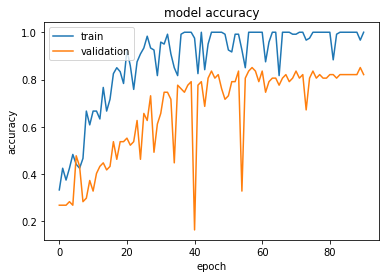

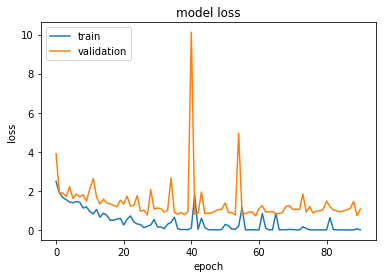

In [18]:
## TODO: Visualize the training and validation loss of your neural network
import matplotlib.pyplot as plt
def plt_hist(hist):
    print(hist.history.keys())
    # summarize history for accuracy
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
plt_hist(hist)

In [21]:
score = my_model.evaluate(test_tensors, test_targets, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

58/58 [==============================] - 1s     
Test loss: 0.925394950242
Test accuracy: 0.75862072254


The testing accuracy is 76%, much lower than I expected as there is only 7 classes. I tried to fine tune the number of layers and neurons in the dense layers, but didn't improve much. Maybe it's due to too limited number of images.

## Part 3 - Improve accuracy with more images
More images were added to existing folder, just need to refresh the tensors and models.

In [ ]:
train_tensors = paths_to_tensor(train_faces).astype('float32')/255
test_tensors = paths_to_tensor(test_faces).astype('float32')/255
validate_tensors = paths_to_tensor(validate_faces).astype('float32')/255
print("Train tensor shape.", train_tensors.shape)
print('Test tensor shape.', test_tensors.shape)
print('Validate tensor shape.', validate_tensors.shape)

In [ ]:
my_model = Model(inputs = base_model.input, outputs = x)
my_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='my_model.h5',
                              verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, cooldown=0, min_lr=0.00001)
lr_print = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('lr:', K.eval(my_model.optimizer.lr)))

In [ ]:
hist = my_model.fit(train_tensors, train_targets,
            validation_data=(validate_tensors, validate_targets),
            epochs=200, verbose=1, batch_size=20,
            callbacks=[checkpointer, early_stopping, reduce_lr, lr_print])

In [ ]:
plt_hist(hist)

In [ ]:
score = my_model.evaluate(test_tensors, test_targets, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])